# k-Nearest Neighbors

### Import the Dataset

In [17]:
import pandas as pd
df = pd.read_csv("2017 DC LAR.csv",sep="|")

c:\users\spdys\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,3,4,5,6,8,9,14,15,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,32,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Prepare the dataset for modeling

In [18]:
# clean the dataset
logData = df.copy(deep=True)

colsToKeep = [
    #"Respondent ID",
    "Loan To Income Ratio",
    "Agency Code",
    "Loan Type",
    "Property Type",
    "Loan Purpose",
    "Occupancy",
    #"Loan Amount (000s)",
    #"Preapproval", #sparsely populated
    "Action Type",
    #"Applicant Ethnicity",  #sparsely populated
    #"Co Applicant Ethnicity",  #sparsely populated
    "Applicant Race 1",
    "Co Applicant Race 1",
    "Applicant Sex",
    "Co Applicant Sex",
    #"Applicant Income (000s)",
    #"Purchaser Type",  #appears to indicate whether or not the application was denied
    #"Rate Spread",  #sparsely populated
    "HOEPA Status",
    "Lien Status",
    "Population",
    "Minority Population %",
    "FFIEC Median Family Income",
    "Tract to MSA/MD Income %",
    "Number of Owner-occupied units",
    "Number of 1-to 4-Family units",
    "Small Institution"
]

logData = logData[colsToKeep]

logData = logData.dropna()

### k-Nearest Neighbors Model for Denials

In [19]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score


# build feature and label arrays
labels = np.array(logData["Action Type"])

features = logData.loc[:, logData.columns != "Action Type"]
features = pd.get_dummies(features)
feature_labels = list(features.columns)
features = np.array(features)


# train test split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 0)


# Declare the standard scaler
std_scaler = StandardScaler()
train_features = std_scaler.fit_transform(train_features)
test_features = std_scaler.transform(test_features)


# model
overall_accuracy, denial_accuracy, weight_type, kval = [],[],[],[] 
for w in ["uniform","distance"]:
    for i in range(100):
        class_weight_param = w
        knn = KNeighborsClassifier(n_neighbors=i+1, weights=class_weight_param)
        knn.fit(train_features, train_labels)


        # Test the model
        predicted_labels = knn.predict(test_features)


        # view results
        results = pd.crosstab(test_labels, predicted_labels, rownames=["Actual"],colnames=["Predicted"])


        # present accuracy measures
        weight_type.append(w)
        overall_accuracy.append(accuracy_score(test_labels, predicted_labels))
        denial_accuracy.append(results.loc["Denied","Denied"]/results.loc["Denied"].sum())
        kval.append(i)

c:\users\spdys\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Results

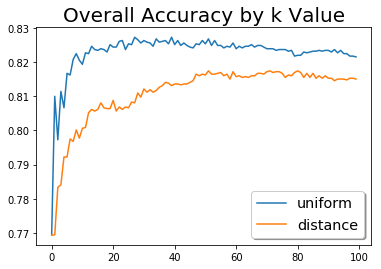

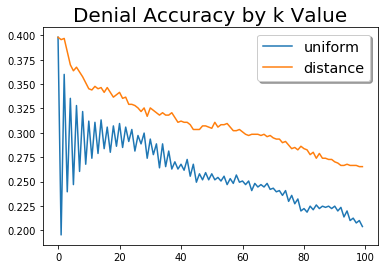

In [20]:
import matplotlib.pyplot as plt

results_df = pd.DataFrame()
results_df["Weight Type"] = weight_type
results_df["k"] = kval
results_df["Overall Accuracy"] = overall_accuracy
results_df["Denial Accuracy"] = denial_accuracy

for w in ["uniform","distance"]:
    plt.title("Overall Accuracy by k Value",fontsize=20)
    plt.plot(results_df[results_df["Weight Type"] == w]["k"],results_df[results_df["Weight Type"] == w]["Overall Accuracy"],label=w)
    plt.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.show()

for w in ["uniform","distance"]:
    plt.title("Denial Accuracy by k Value",fontsize=20)
    plt.plot(results_df[results_df["Weight Type"] == w]["k"],results_df[results_df["Weight Type"] == w]["Denial Accuracy"],label=w)
    plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()

### Analysis

#### Brief Overview
- Even values for k are unreliable when you have a binary classifier because the model randomly breaks ties.  See the "Denial Accuracy by k Value" chart.
- Overall accuracy rises moderately
- Prone to same bias errors as other models resulting from imbalance.  More prone to bias as k rises.
- Attempt to correct this with distance weighting function, where further neighbors are given less weight in each sample's prediction.

#### Summary
- Low predictive value.
- Low interpretive value, which is inappropiate for purpose of understanding how loan application characteristics affect approval.